# Dask Array Support to AnnData

## Initalizing

First let's do our imports and initalize adata objects with the help of the `adata_with_dask` function defined below.

In [1]:
import dask
import dask.array as da
import numpy as np
import pandas as pd
import anndata as ad

In [2]:
def adata_with_dask(M, N):
    adata_dict = {}
    adata_dict["X"] = da.random.random((M, N))
    adata_dict["dtype"] = np.float64
    adata_dict["obsm"] = dict(
        a=da.random.random((M, 100)),
    )
    adata_dict["layers"] = dict(
        a=da.random.random((M, N)),
    )
    adata_dict["obs"] = pd.DataFrame(
        {"batch": np.random.choice(["a", "b"], M)},
        index=[f"cell{i:03d}" for i in range(M)],
    )
    adata_dict["var"] = pd.DataFrame(index=[f"gene{i:03d}" for i in range(N)])
    
    
    return ad.AnnData(**adata_dict)

Here is how our adata looks like

In [3]:
adata = adata_with_dask(10000,10000)
adata

AnnData object with n_obs × n_vars = 10000 × 10000
    obs: 'batch'
    obsm: 'a'
    layers: 'a'

## Representation of Dask Arrays

Dask arrays consists of chunks that can be distributed in clusters. In the figure below, each small square represents a chunk that form a dask array. In principle these some of these chunks could be in different machines (clusters).

In [4]:
adata.X

dask.array<random_sample, shape=(10000, 10000), dtype=float64, chunksize=(2500, 2500), chunktype=numpy.ndarray>

In [5]:
adata.obsm['a']

dask.array<random_sample, shape=(10000, 100), dtype=float64, chunksize=(10000, 100), chunktype=numpy.ndarray>

## The Computation Graph
The graph layer in the `Count` row refers to the layer of the computation graph of the chunks, i.e. which operations are applied to them. We have this because the operations done on Dask arrays aren't computed instantly. This way, Dask array can optimize the queries we issued to it. It also won't keep our resources occupied for the results we expect later. Below is a representation of the chunks we initially created.

In [6]:
dask.config.set({"visualization.engine": "ipycytoscape"})
adata.X.visualize()

CytoscapeWidget(cytoscape_layout={'name': 'dagre', 'rankDir': 'BT', 'nodeSep': 10, 'edgeSep': 10, 'spacingFact…

In [7]:
adata.X.visualize(filename="s.svg")

CytoscapeWidget(cytoscape_layout={'name': 'dagre', 'rankDir': 'BT', 'nodeSep': 10, 'edgeSep': 10, 'spacingFact…

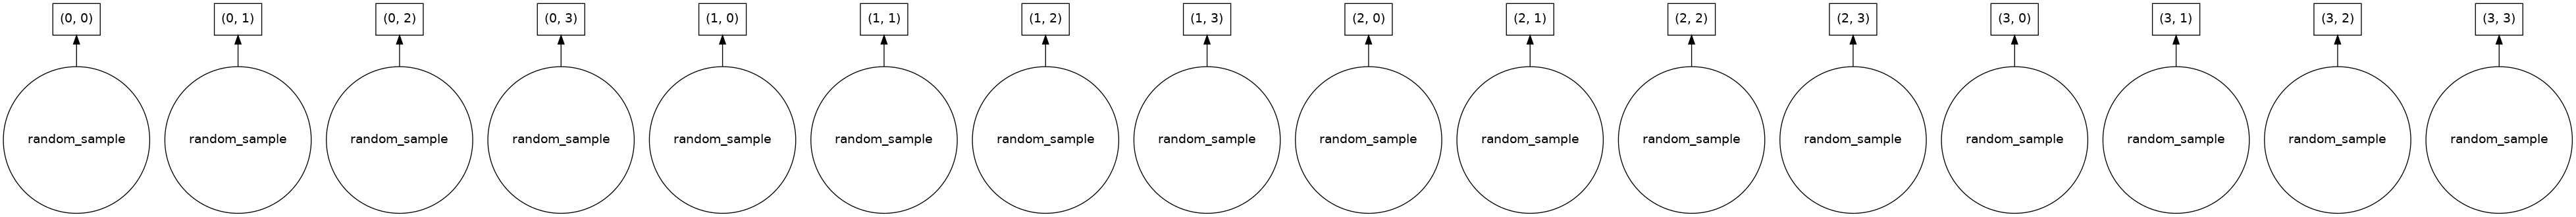

In [8]:
dask.config.set({"visualization.engine": "graphviz"})
adata.X.visualize()

We now show an example for this computation graph on dask arrays to understand it better. This part is not technically relevant to AnnData.

In [9]:
xsum = adata.X.sum(axis=1) # do a sum on axis=1
xsum

dask.array<sum-aggregate, shape=(10000,), dtype=float64, chunksize=(2500,), chunktype=numpy.ndarray>

Note that this computation isn't necessarily done yet, but rather saved to actually run it later.   If we investigate the computation graph of this result, we can see that for this operation some chunks aren't dependent on each other. This might give a hint to the Dask framework to store the chunks that depend on each other to the same cluster. For this simple exercise, all the chunks can be stored in one machine, but when it is impossible to store all the four chunks into one machine this will come in handy.

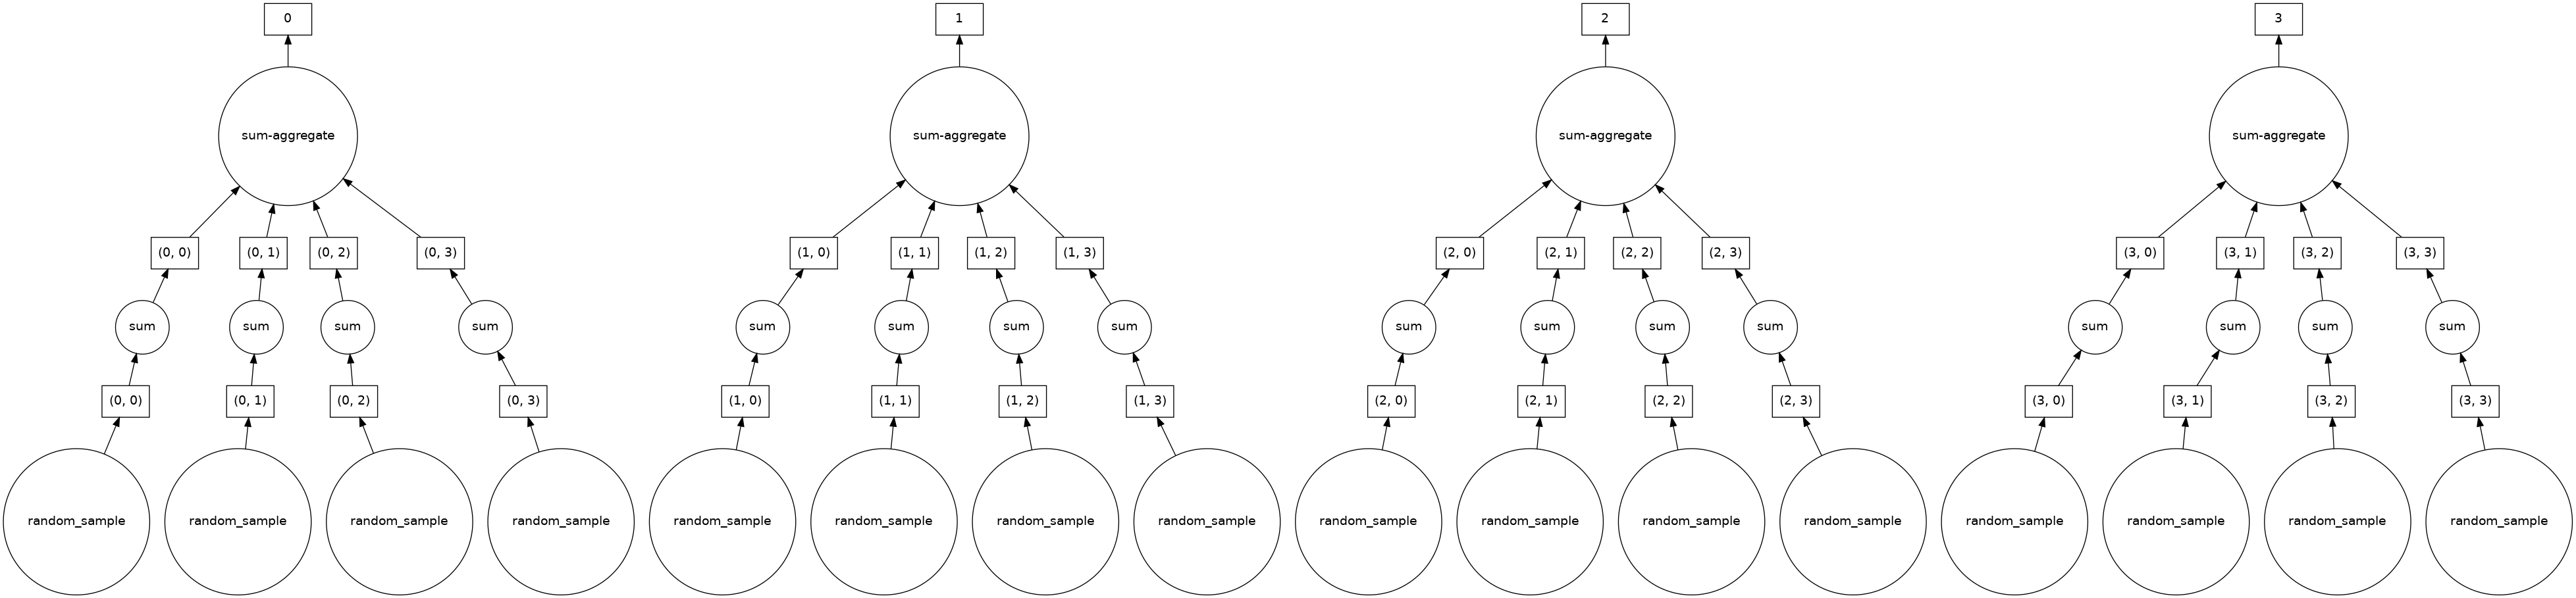

In [10]:
xsum.visualize()

But coming back to our anndata tutorial we will see that nothing changed in our adata.

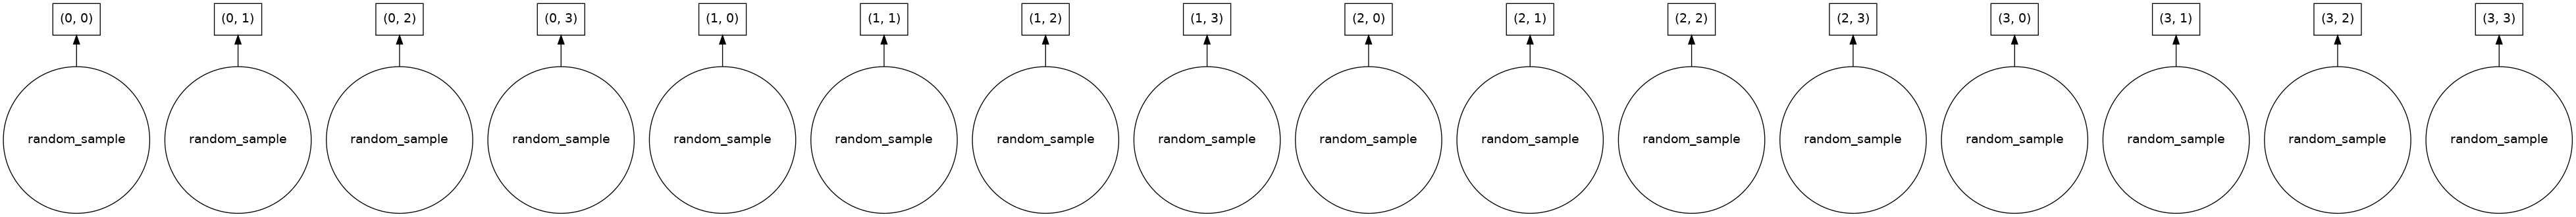

In [11]:
adata.X.visualize()

## Concatenation

In this section we will cover how concatenation on anndata objects that use Dask arrays looks like. We first create another anndata object to concatenate with.

In [12]:
adata2 = adata_with_dask(10000,10000)
adata2

AnnData object with n_obs × n_vars = 10000 × 10000
    obs: 'batch'
    obsm: 'a'
    layers: 'a'

We can see that the X attribute of adata also consist of four chunks.

In [13]:
adata2.X

dask.array<random_sample, shape=(10000, 10000), dtype=float64, chunksize=(2500, 2500), chunktype=numpy.ndarray>

In [14]:
adata_concat = ad.concat([adata,adata2],index_unique='id')

When we concatenate the whole object you can see that in the X of the result consists of eight chunks and they quite probably are just the source chunks aligned.

In [15]:
adata_concat.X

dask.array<concatenate, shape=(20000, 10000), dtype=float64, chunksize=(2500, 2500), chunktype=numpy.ndarray>

To confirm this we look at the computation graph. We can confirm that this new object's X is just the chunks of source X's put together.

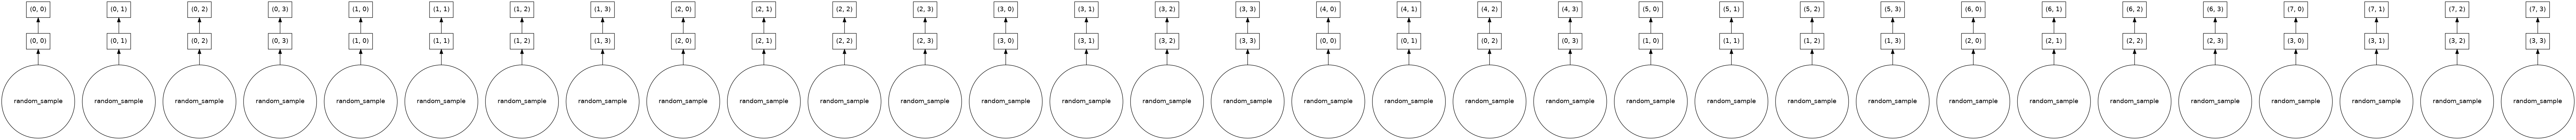

In [16]:
adata_concat.X.visualize()

Here for the obsm we also this. The chunk from both are just stacked on top.

In [17]:
adata_concat.obsm['a']

dask.array<concatenate, shape=(20000, 100), dtype=float64, chunksize=(10000, 100), chunktype=numpy.ndarray>

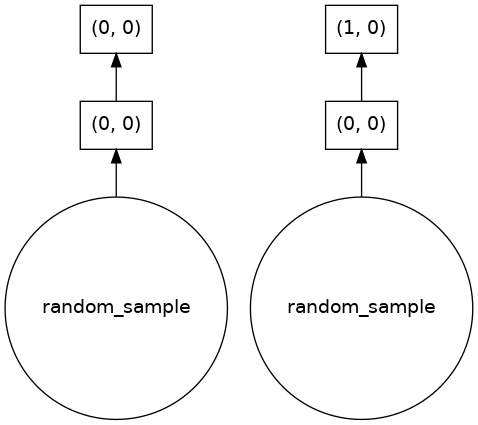

In [18]:
adata_concat.obsm['a'].visualize()

## Views

Let's see how our views of anndata objects play with Dask arrays.

### Slice View



We take a slice of the concatenated adatas. This operation returns a view of the adata which means that the resulting adata holds a view of the source adata's Dask array, namely the `DaskArrayView` class,  which is a completely different object than Dask array.

In [19]:
adata_slice_view = adata_concat[:500, :][:, :500]

Below, you can see the values of the X attribute of the result. Which implies that the resulting object isn't "lazy" like Dask arrays. 

In [20]:
adata_slice_view.X, adata_slice_view.shape

(DaskArrayView([[0.72838502, 0.61350575, 0.40022621, ..., 0.50330432,
                 0.85333378, 0.58849856],
                [0.42185937, 0.42565931, 0.57309764, ..., 0.08547006,
                 0.88248961, 0.2421325 ],
                [0.1365442 , 0.97464414, 0.07918248, ..., 0.16051749,
                 0.91317825, 0.17699392],
                ...,
                [0.5806419 , 0.99348744, 0.41316208, ..., 0.07489666,
                 0.55653277, 0.54894602],
                [0.12280635, 0.81018587, 0.90071752, ..., 0.59211236,
                 0.18583465, 0.63932545],
                [0.83123587, 0.32169456, 0.80628685, ..., 0.33271316,
                 0.74254286, 0.86753114]]),
 (500, 500))

But our original adata remains unchanged.

In [21]:
adata_concat.X

dask.array<concatenate, shape=(20000, 10000), dtype=float64, chunksize=(2500, 2500), chunktype=numpy.ndarray>

### Index List View

In [22]:
small_view = adata_concat[[12,12,3,5,53],[1,2,5]]
small_view

View of AnnData object with n_obs × n_vars = 5 × 3
    obs: 'batch'
    obsm: 'a'
    layers: 'a'

In [23]:
small_view.X

DaskArrayView([[0.52510827, 0.10516782, 0.26431531],
               [0.52510827, 0.10516782, 0.26431531],
               [0.8529617 , 0.5811387 , 0.87819351],
               [0.3983604 , 0.3881361 , 0.73948685],
               [0.70476938, 0.11036871, 0.68859036]])

### View by Category

In [24]:
categ_view = adata_concat[adata_concat.obs['batch'] == 'b']

In [25]:
categ_view.X

DaskArrayView([[0.72838502, 0.61350575, 0.40022621, ..., 0.90661766,
                0.26303362, 0.84463228],
               [0.85973303, 0.38493087, 0.14562543, ..., 0.83942913,
                0.23550707, 0.20914392],
               [0.3856279 , 0.2634741 , 0.02730721, ..., 0.27813116,
                0.69056665, 0.59318778],
               ...,
               [0.92814102, 0.56444149, 0.14745331, ..., 0.89153355,
                0.71780893, 0.74999952],
               [0.08176103, 0.34641133, 0.69769804, ..., 0.14463862,
                0.30459374, 0.13489856],
               [0.63777886, 0.59855541, 0.43825   , ..., 0.67486904,
                0.19648625, 0.39410524]])

## To Memory

In [26]:
adata_concat.X

dask.array<concatenate, shape=(20000, 10000), dtype=float64, chunksize=(2500, 2500), chunktype=numpy.ndarray>

Here no copies are made, only the result of the lazy object is asked to be materialized.

In [27]:
adata_mem = adata_concat.to_memory(copy=False)
adata_mem.X

array([[0.72838502, 0.61350575, 0.40022621, ..., 0.90661766, 0.26303362,
        0.84463228],
       [0.42185937, 0.42565931, 0.57309764, ..., 0.14258193, 0.24490017,
        0.96847237],
       [0.1365442 , 0.97464414, 0.07918248, ..., 0.51019851, 0.27782187,
        0.86231644],
       ...,
       [0.92814102, 0.56444149, 0.14745331, ..., 0.89153355, 0.71780893,
        0.74999952],
       [0.08176103, 0.34641133, 0.69769804, ..., 0.14463862, 0.30459374,
        0.13489856],
       [0.63777886, 0.59855541, 0.43825   , ..., 0.67486904, 0.19648625,
        0.39410524]])

If you want to both materialize the result and copy.

In [28]:
del adata_mem

In [29]:
adata_mem = adata_concat.to_memory(copy=True)
adata_mem.X

array([[0.72838502, 0.61350575, 0.40022621, ..., 0.90661766, 0.26303362,
        0.84463228],
       [0.42185937, 0.42565931, 0.57309764, ..., 0.14258193, 0.24490017,
        0.96847237],
       [0.1365442 , 0.97464414, 0.07918248, ..., 0.51019851, 0.27782187,
        0.86231644],
       ...,
       [0.92814102, 0.56444149, 0.14745331, ..., 0.89153355, 0.71780893,
        0.74999952],
       [0.08176103, 0.34641133, 0.69769804, ..., 0.14463862, 0.30459374,
        0.13489856],
       [0.63777886, 0.59855541, 0.43825   , ..., 0.67486904, 0.19648625,
        0.39410524]])

# IO operations

Read/Write operations on `h5ad` and `Zarr` are supported. One should note that the lazy objects are materialized when this is called. For now, the anndata loaded from file won't be loaded with dask arrays in it.

## Write h5ad

In [30]:
adata = adata_with_dask(100,100)

In [31]:
adata.write_h5ad('a1.h5ad')

In [32]:
adata.X

dask.array<random_sample, shape=(100, 100), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>

## Read h5ad

In [33]:
h5ad_adata = ad.read_h5ad('a1.h5ad')

In [34]:
h5ad_adata.X

array([[0.23367211, 0.20439802, 0.52705836, ..., 0.45265045, 0.43279515,
        0.46198524],
       [0.81091976, 0.42469778, 0.67839436, ..., 0.15638244, 0.70276627,
        0.97066302],
       [0.16305392, 0.76852337, 0.97080307, ..., 0.14606363, 0.57022887,
        0.64740224],
       ...,
       [0.71136848, 0.97518576, 0.32288938, ..., 0.29400568, 0.8114202 ,
        0.0133644 ],
       [0.15581635, 0.34744519, 0.31299673, ..., 0.78559557, 0.38347609,
        0.13241481],
       [0.33989337, 0.97802658, 0.35500007, ..., 0.09771887, 0.87390785,
        0.29690495]])

## Write zarr

In [35]:
adata.write_zarr('a2.zarr')

In [36]:
adata.X

dask.array<random_sample, shape=(100, 100), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>

## Read zarr

In [37]:
zarr_adata = ad.read_zarr('a2.zarr')

In [38]:
zarr_adata.X

array([[0.23367211, 0.20439802, 0.52705836, ..., 0.45265045, 0.43279515,
        0.46198524],
       [0.81091976, 0.42469778, 0.67839436, ..., 0.15638244, 0.70276627,
        0.97066302],
       [0.16305392, 0.76852337, 0.97080307, ..., 0.14606363, 0.57022887,
        0.64740224],
       ...,
       [0.71136848, 0.97518576, 0.32288938, ..., 0.29400568, 0.8114202 ,
        0.0133644 ],
       [0.15581635, 0.34744519, 0.31299673, ..., 0.78559557, 0.38347609,
        0.13241481],
       [0.33989337, 0.97802658, 0.35500007, ..., 0.09771887, 0.87390785,
        0.29690495]])

Notice how they are loaded as arrays rather than dask arrays.

## Dask Array Support for Other Fields

This is the list of operations and in which fields they are supported, although some might have not been covered in this tutorial.

The following work with operations anndata supported before are also supported now with Dask arrays:
- anndata.concat()
- Views
- copy()
- to_memory() (changed behaviour)
- read/write on h5ad/zarr

**X, obsm, varm, obsp, varp, layers, uns, and raw** attributes are all supported and tested.

Note: scipy.sparse array wrapped with dask array doesn't play well. This is mainly because of the inconsistent numpy api support of scipy.sparse. Even though not explicitly tested, a sparse array that supports the numpy api should theoretically work well.